# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](https://compsci682.github.io/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [1]:
import random
import numpy as np
from asgn1.data_utils import load_CIFAR10
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [2]:
from asgn1.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
  # Load the raw CIFAR-10 data
  cifar10_dir = 'datasets/cifar-10-batches-py'
  X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
  
  # Subsample the data
  mask = range(num_training, num_training + num_validation)
  X_val = X_train[mask]
  y_val = y_train[mask]
  mask = range(num_training)
  X_train = X_train[mask]
  y_train = y_train[mask]
  mask = range(num_test)
  X_test = X_test[mask]
  y_test = y_test[mask]

  return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for the bonus section.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each row is the concatenation of all feature vectors for a single image.

In [3]:
from asgn1.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [4]:
# Use the validation set to tune the learning rate and regularization strength

from asgn1.classifiers.linear_classifier import LinearSVM

learning_rates = [1e-9, 1e-8, 1e-7, 1.8e-7]
regularization_strengths = [1e5, 1e6, 1e7, 1e4]

results = {}
best_val = -1
best_svm = None






################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
lr_rg_pairs = [(i, j) for i in learning_rates for j in regularization_strengths]
num_iterations = 1500
for lr, rg in lr_rg_pairs:
    svm = LinearSVM()
    loss_hist = svm.train(X_train_feats, y_train, learning_rate=lr, reg=rg, num_iters=num_iterations, verbose=True)
    y_train_pred = svm.predict(X_train_feats)
    training_accuracy = np.mean(y_train == y_train_pred)
    print 'training accuracy: %f' % (training_accuracy, )
    y_val_pred = svm.predict(X_val_feats)
    validation_accuracy = np.mean(y_val == y_val_pred)
    print 'validation accuracy: %f' % (validation_accuracy, )
    results[(lr,rg)] = (training_accuracy,validation_accuracy ) 
    if(best_val<validation_accuracy):
        best_val = validation_accuracy
        best_svm = svm


################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print 'lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy)
    
print 'best validation accuracy achieved during cross-validation: %f' % best_val

iteration 0 / 1500: loss 89.557366
iteration 100 / 1500: loss 87.963142
iteration 200 / 1500: loss 86.397896
iteration 300 / 1500: loss 84.877641
iteration 400 / 1500: loss 83.374096
iteration 500 / 1500: loss 81.890126
iteration 600 / 1500: loss 80.448593
iteration 700 / 1500: loss 79.023396
iteration 800 / 1500: loss 77.650147
iteration 900 / 1500: loss 76.296193
iteration 1000 / 1500: loss 74.936712
iteration 1100 / 1500: loss 73.656084
iteration 1200 / 1500: loss 72.372019
iteration 1300 / 1500: loss 71.118534
iteration 1400 / 1500: loss 69.872301
training accuracy: 0.098714
validation accuracy: 0.097000
iteration 0 / 1500: loss 778.251911
iteration 100 / 1500: loss 638.748091
iteration 200 / 1500: loss 524.550385
iteration 300 / 1500: loss 431.054343
iteration 400 / 1500: loss 354.519968
iteration 500 / 1500: loss 291.862802
iteration 600 / 1500: loss 240.564562
iteration 700 / 1500: loss 198.565696
iteration 800 / 1500: loss 164.195395
iteration 900 / 1500: loss 136.041289
iterat

In [5]:
# Evaluate your trained SVM on the test set
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print test_accuracy

0.415


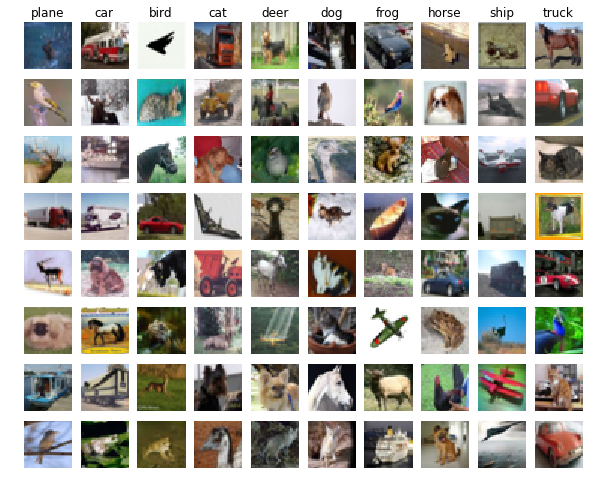

In [6]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?

Ship - There are certain images that have a blue background without a ship that are misclassified. It does make sense that a blue background highly indicates the possibility of a ship


Frog - There are certain images that have a high green component to it which indicates thatit could be a frog.

Deer - There are certain images that have a green background to it that might indicate thatit could be a deer.

Car and Truck are closely related, so sometimes a car is classified as a truck and a truck is classified as a car.

Plane and ship might be switched in cases , since both of them mostly have a blue background.

Since animals have some common characterestics, we can see them being misclassified in the other buckets. Like cat and dog may be switched, a cat is misclassified as a dog here.

Bird may be in trees and may be misclassified with deer and vice versa



## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [7]:
print X_train_feats.shape

(49000, 155)


In [8]:
from asgn1.classifiers.neural_net import TwoLayerNet

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10



################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################


results = {}
best_net = None
best_val = -1 
# learning_rates = [1e-3]
# regularization_strengths = [1.0]
# learning_rates = [1e-9, 1e-8, 1e-7]
learning_rates = [1e-1,2e-1,3e-1,4e-1,5e-1,6e-1,7e-1,8e-1,9e-1,10e-1,5.4e-2]
# learning_rates = [1e-1]
regularization_strengths = [1e-2, 1e-1, 1e0, 1e1]
# regularization_strengths = [1e-2]


# learning_rates = [1e1,1e0,1e-1,1e-2,1e-3,1e-4,1e-5] # 38.5
# regularization_strengths = [1,10]# learning_rates = [1e1,1e0,1e-1,1e-2,1e-3,1e-4,1e-5] # 38.5
# learning_rates = [2.5e-1,5.6e-2,10e-3] # 38.5

bt_sizes = [200,250] # 200
num_iterations = [1000]
lr_decays = [0.95,0.925]
lr_rg_pairs = [(lr, rg, btsize, it, lr_decay) for lr in learning_rates for rg in regularization_strengths for btsize in bt_sizes for it in num_iterations for lr_decay in lr_decays]
print lr_rg_pairs


for lr, rg, bt_size,num_iterations,lr_decay in lr_rg_pairs:
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    loss_hist = net.train(X_train_feats, y_train, X_val_feats, y_val, num_iters=num_iterations, batch_size=bt_size, 
                          learning_rate=lr, learning_rate_decay=lr_decay, reg=rg, verbose=True)
    y_train_pred = net.predict(X_train_feats)
    training_accuracy = np.mean(y_train == y_train_pred)
    print 'training accuracy: %f' % (training_accuracy, )
    y_val_pred = net.predict(X_val_feats)
    validation_accuracy = np.mean(y_val == y_val_pred)
    print 'validation accuracy: %f' % (validation_accuracy, )
    results[(lr,rg, bt_size,num_iterations,lr_decay)] = (training_accuracy,validation_accuracy ) 
    if(best_val<validation_accuracy):
        best_val = validation_accuracy
        best_net = net


################################################################################
#                              END OF YOUR CODE                                #
################################################################################

[(0.1, 0.01, 200, 1000, 0.95), (0.1, 0.01, 200, 1000, 0.925), (0.1, 0.01, 250, 1000, 0.95), (0.1, 0.01, 250, 1000, 0.925), (0.1, 0.1, 200, 1000, 0.95), (0.1, 0.1, 200, 1000, 0.925), (0.1, 0.1, 250, 1000, 0.95), (0.1, 0.1, 250, 1000, 0.925), (0.1, 1.0, 200, 1000, 0.95), (0.1, 1.0, 200, 1000, 0.925), (0.1, 1.0, 250, 1000, 0.95), (0.1, 1.0, 250, 1000, 0.925), (0.1, 10.0, 200, 1000, 0.95), (0.1, 10.0, 200, 1000, 0.925), (0.1, 10.0, 250, 1000, 0.95), (0.1, 10.0, 250, 1000, 0.925), (0.2, 0.01, 200, 1000, 0.95), (0.2, 0.01, 200, 1000, 0.925), (0.2, 0.01, 250, 1000, 0.95), (0.2, 0.01, 250, 1000, 0.925), (0.2, 0.1, 200, 1000, 0.95), (0.2, 0.1, 200, 1000, 0.925), (0.2, 0.1, 250, 1000, 0.95), (0.2, 0.1, 250, 1000, 0.925), (0.2, 1.0, 200, 1000, 0.95), (0.2, 1.0, 200, 1000, 0.925), (0.2, 1.0, 250, 1000, 0.95), (0.2, 1.0, 250, 1000, 0.925), (0.2, 10.0, 200, 1000, 0.95), (0.2, 10.0, 200, 1000, 0.925), (0.2, 10.0, 250, 1000, 0.95), (0.2, 10.0, 250, 1000, 0.925), (0.3, 0.01, 200, 1000, 0.95), (0.3, 0.0

asgn1/classifiers/neural_net.py:111: RuntimeWarning: divide by zero encountered in log
  loss = -1 * np.sum(np.log(ProbabilityMatrix[range(len(ProbabilityMatrix)),y]))


iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf


asgn1/classifiers/neural_net.py:106: RuntimeWarning: overflow encountered in subtract
  duplicate_copy_scores = duplicate_copy_scores - np.max(duplicate_copy_scores,axis=1).reshape(len(duplicate_copy_scores),1)
asgn1/classifiers/neural_net.py:113: RuntimeWarning: overflow encountered in double_scalars
  loss += 0.5*reg* np.sum(W1*W1) + 0.5*reg* np.sum(W2*W2)
asgn1/classifiers/neural_net.py:106: RuntimeWarning: invalid value encountered in subtract
  duplicate_copy_scores = duplicate_copy_scores - np.max(duplicate_copy_scores,axis=1).reshape(len(duplicate_copy_scores),1)
asgn1/classifiers/neural_net.py:84: RuntimeWarning: invalid value encountered in less
  hiddenLayerScores[hiddenLayerScores<0] = 0
asgn1/classifiers/neural_net.py:143: RuntimeWarning: invalid value encountered in greater
  hiddenLayerScoresGreaterThanZero[hiddenLayerScoresGreaterThanZero>0] = 1


iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 1000: loss 2.306690
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 1000: loss 2.306708
iteration 100 / 1000: loss inf
iteration 200 / 1000: loss inf
iteration 300 / 1000: loss inf
iteration 400 / 1000: loss inf
iteration 500 / 1000: loss inf
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 1000: loss 2.306716
iteration 100 / 1000: loss inf
iteration 2

In [9]:
# Run your neural net classifier on the test set. You should be able to
# get more than 55% accuracy.
print results
test_acc = (best_net.predict(X_test_feats) == y_test).mean()
print test_acc

{(0.5, 0.01, 200, 1000, 0.95): (0.54702040816326536, 0.53900000000000003), (0.3, 0.1, 250, 1000, 0.925): (0.43085714285714288, 0.432), (0.054, 0.01, 250, 1000, 0.925): (0.43904081632653064, 0.42399999999999999), (0.6, 0.1, 250, 1000, 0.925): (0.42899999999999999, 0.39500000000000002), (0.2, 0.1, 250, 1000, 0.95): (0.43761224489795919, 0.436), (0.7, 1.0, 200, 1000, 0.95): (0.10026530612244898, 0.086999999999999994), (0.9, 1.0, 250, 1000, 0.925): (0.099755102040816321, 0.112), (1.0, 1.0, 250, 1000, 0.925): (0.099897959183673474, 0.105), (0.3, 10.0, 250, 1000, 0.925): (0.10026530612244898, 0.086999999999999994), (0.5, 10.0, 250, 1000, 0.95): (0.10026530612244898, 0.086999999999999994), (0.2, 0.01, 250, 1000, 0.95): (0.53518367346938778, 0.52700000000000002), (0.4, 10.0, 250, 1000, 0.925): (0.10026530612244898, 0.086999999999999994), (0.1, 10.0, 250, 1000, 0.95): (0.10026530612244898, 0.086999999999999994), (0.054, 10.0, 200, 1000, 0.95): (0.099612244897959182, 0.11899999999999999), (0.5, 

In [10]:
#BASELINE PERFORMANCE FOR EACH CLASS ::::

print " USING HOG, COLOR HISTOGRAM ******  "

print "PLANE :  : ", (best_net.predict(X_test_feats[y_test == 0]) == y_test[y_test == 0]).mean()
print "car :  : ", (best_net.predict(X_test_feats[y_test == 1]) == y_test[y_test == 1]).mean()
print "bird :  : ", (best_net.predict(X_test_feats[y_test == 2]) == y_test[y_test == 2]).mean()
print "cat :  : ", (best_net.predict(X_test_feats[y_test == 3]) == y_test[y_test == 3]).mean()
print "deer :  : ", (best_net.predict(X_test_feats[y_test == 4]) == y_test[y_test == 4]).mean()
print "dog :  : ", (best_net.predict(X_test_feats[y_test == 5]) == y_test[y_test == 5]).mean()
print "frog :  : ", (best_net.predict(X_test_feats[y_test == 6]) == y_test[y_test == 6]).mean()
print "horse :  : ", (best_net.predict(X_test_feats[y_test == 7]) == y_test[y_test == 7]).mean()
print "ship :  : ", (best_net.predict(X_test_feats[y_test == 8]) == y_test[y_test == 8]).mean()
print "truck :  : ", (best_net.predict(X_test_feats[y_test == 9]) == y_test[y_test == 9]).mean()



 USING HOG, COLOR HISTOGRAM ******  
PLANE :  :  0.495145631068
car :  :  0.719101123596
bird :  :  0.43
cat :  :  0.417475728155
deer :  :  0.488888888889
dog :  :  0.348837209302
frog :  :  0.660714285714
horse :  :  0.598039215686
ship :  :  0.584905660377
truck :  :  0.56880733945


# Bonus: Do something extra!
Use the material and code we have presented in this assignment to do something interesting. Was there another question we should have asked? Did any cool ideas pop into your head as you were working on the assignment? This is your chance to show off!

In [11]:
### I AM USING DIMENSIONALITY REDUCTION TO REDUCE THE NUMBER OF FEATURES TO 100.

from sklearn.decomposition import PCA

pca = PCA(n_components=100)

pca_x = pca.fit_transform(X_train_feats)
pca_valid_x = pca.transform(X_val_feats)
pca_test_x = pca.transform(X_test_feats)


input_dim = pca_x.shape[1]
hidden_dim = 500
num_classes = 10


results_dim = {}
best_net_dim = None
best_val_dim = -1 
# learning_rates = [1e-3]
# regularization_strengths = [1.0]
# learning_rates = [1e-9, 1e-8, 1e-7]
learning_rates = [1e-1,2e-1,3e-1,4e-1,5e-1,6e-1,7e-1,8e-1,9e-1,10e-1,5.4e-2]

regularization_strengths = [1e-2, 1e-2, 1e0, 1e1]


# learning_rates = [1e1,1e0,1e-1,1e-2,1e-3,1e-4,1e-5] # 38.5
# regularization_strengths = [1,10]# learning_rates = [1e1,1e0,1e-1,1e-2,1e-3,1e-4,1e-5] # 38.5
# learning_rates = [2.5e-1,5.6e-2,10e-3] # 38.5

bt_sizes = [200,250] # 200
num_iterations = [1000]
lr_decays = [0.95,0.925]
lr_rg_pairs = [(lr, rg, btsize, it, lr_decay) for lr in learning_rates for rg in regularization_strengths for btsize in bt_sizes for it in num_iterations for lr_decay in lr_decays]
print lr_rg_pairs


for lr, rg, bt_size,num_iterations,lr_decay in lr_rg_pairs:
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    loss_hist = net.train(pca_x, y_train, pca_valid_x, y_val, num_iters=num_iterations, batch_size=bt_size, 
                          learning_rate=lr, learning_rate_decay=lr_decay, reg=rg, verbose=True)
    y_train_pred = net.predict(pca_x)
    training_accuracy = np.mean(y_train == y_train_pred)
    print 'training accuracy: %f' % (training_accuracy, )
    y_val_pred = net.predict(pca_valid_x)
    validation_accuracy = np.mean(y_val == y_val_pred)
    print 'validation accuracy: %f' % (validation_accuracy, )
    results_dim[(lr,rg, bt_size,num_iterations,lr_decay)] = (training_accuracy,validation_accuracy ) 
    if(best_val_dim<validation_accuracy):
        best_val_dim = validation_accuracy
        best_net_dim = net



[(0.1, 0.01, 200, 1000, 0.95), (0.1, 0.01, 200, 1000, 0.925), (0.1, 0.01, 250, 1000, 0.95), (0.1, 0.01, 250, 1000, 0.925), (0.1, 0.01, 200, 1000, 0.95), (0.1, 0.01, 200, 1000, 0.925), (0.1, 0.01, 250, 1000, 0.95), (0.1, 0.01, 250, 1000, 0.925), (0.1, 1.0, 200, 1000, 0.95), (0.1, 1.0, 200, 1000, 0.925), (0.1, 1.0, 250, 1000, 0.95), (0.1, 1.0, 250, 1000, 0.925), (0.1, 10.0, 200, 1000, 0.95), (0.1, 10.0, 200, 1000, 0.925), (0.1, 10.0, 250, 1000, 0.95), (0.1, 10.0, 250, 1000, 0.925), (0.2, 0.01, 200, 1000, 0.95), (0.2, 0.01, 200, 1000, 0.925), (0.2, 0.01, 250, 1000, 0.95), (0.2, 0.01, 250, 1000, 0.925), (0.2, 0.01, 200, 1000, 0.95), (0.2, 0.01, 200, 1000, 0.925), (0.2, 0.01, 250, 1000, 0.95), (0.2, 0.01, 250, 1000, 0.925), (0.2, 1.0, 200, 1000, 0.95), (0.2, 1.0, 200, 1000, 0.925), (0.2, 1.0, 250, 1000, 0.95), (0.2, 1.0, 250, 1000, 0.925), (0.2, 10.0, 200, 1000, 0.95), (0.2, 10.0, 200, 1000, 0.925), (0.2, 10.0, 250, 1000, 0.95), (0.2, 10.0, 250, 1000, 0.925), (0.3, 0.01, 200, 1000, 0.95), (

In [13]:
print results
test_acc = (best_net_dim.predict(pca_test_x) == y_test).mean()
print test_acc

{(0.5, 0.01, 200, 1000, 0.95): (0.54702040816326536, 0.53900000000000003), (0.3, 0.1, 250, 1000, 0.925): (0.43085714285714288, 0.432), (0.054, 0.01, 250, 1000, 0.925): (0.43904081632653064, 0.42399999999999999), (0.6, 0.1, 250, 1000, 0.925): (0.42899999999999999, 0.39500000000000002), (0.2, 0.1, 250, 1000, 0.95): (0.43761224489795919, 0.436), (0.7, 1.0, 200, 1000, 0.95): (0.10026530612244898, 0.086999999999999994), (0.9, 1.0, 250, 1000, 0.925): (0.099755102040816321, 0.112), (1.0, 1.0, 250, 1000, 0.925): (0.099897959183673474, 0.105), (0.3, 10.0, 250, 1000, 0.925): (0.10026530612244898, 0.086999999999999994), (0.5, 10.0, 250, 1000, 0.95): (0.10026530612244898, 0.086999999999999994), (0.2, 0.01, 250, 1000, 0.95): (0.53518367346938778, 0.52700000000000002), (0.4, 10.0, 250, 1000, 0.925): (0.10026530612244898, 0.086999999999999994), (0.1, 10.0, 250, 1000, 0.95): (0.10026530612244898, 0.086999999999999994), (0.054, 10.0, 200, 1000, 0.95): (0.099612244897959182, 0.11899999999999999), (0.5, 


Used 2 hidden Layers instead of one, Learning Rate is Constant, instead of decaying learning rate.
I also feel shuffling would lead to a better results if solver is SGD, since randomness is helpful while learning weights
since if you always get the same batch again and again, in one iteration your weights might go to the negative end and in the other iteration of a batch your weights goes to the positive end and you end up coming back to the gradient you had previously before these two iterations.


I tried the above as well as the below with a different solver lbfgs.

In [9]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(solver='lbfgs', max_iter=2000, activation='relu', alpha=1e-5, hidden_layer_sizes=(100, 40), shuffle=True)
clf.fit(X_train_feats, y_train)

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100, 40), learning_rate='constant',
       learning_rate_init=0.001, max_iter=2000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='lbfgs', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [10]:
print "Training Accuracy",(clf.predict(X_train_feats) == y_train).mean()
print "Validation Accuracy",(clf.predict(X_val_feats) == y_val).mean()
print "TEST Accuracy",(clf.predict(X_test_feats) == y_test).mean()

Training Accuracy 0.824285714286
Validation Accuracy 0.495
TEST Accuracy 0.491


# Bonus: Design your own features!

You have seen that simple image features can improve classification performance. So far we have tried HOG and color histograms, but other types of features may be able to achieve even better classification performance.

For bonus points, design and implement a new type of feature and use it for image classification on CIFAR-10. Explain how your feature works and why you expect it to be useful for image classification. Implement it in this notebook, cross-validate any hyperparameters, and compare its performance to the HOG + Color histogram baseline.

ANSWER ::: We have the following classes : plane,car, bird, cat, deer, dog, frog, horse, ship, truck

What i plan on targetting is to increase overall accuracy of a few classes that would have corners, so that it can increase the overall accuracy of the classifier. 

Out of these there are 4 objects like plane, car, ship, truck where there are a lot of corners available to it, ignoring the background aspects of it.

But even in cat or dog, it might be indoors, and there would be walls or objects that have corners.

The attribute or feature of the number of corners available would help us in some way to distinguish the class is my hypothesis

For number of corners i have used skimages feature extraction module to get the number of corners

I feel that the addition of the feature with number of corners will prove valuable to identifying the appropriate class. 


**OVERALL PERFORMANCE: (After Hyper Parameter Tuning)**

HOG, HISTOGRAM : 53.4

HOG, HISTOGRAM, NUMBER OF CORNERS : 52.9


**CLASS WISE PERFORMANCE**

**HOG, HISTOGRAM :**

PLANE :  :  0.495145631068

car :  :  0.719101123596

bird :  :  0.43

cat :  :  0.417475728155

deer :  :  0.488888888889

dog :  :  0.348837209302

frog :  :  0.660714285714

horse :  :  0.598039215686

ship :  :  0.584905660377

truck :  :  0.56880733945


**HOG, HISTOGRAM, NUMBER OF CORNERS :  **

PLANE :  :  0.407766990291

car :  :  0.629213483146

bird :  :  0.37

cat :  :  0.456310679612

deer :  :  0.488888888889

dog :  :  0.348837209302

frog :  :  0.642857142857

horse :  :  0.558823529412

ship :  :  0.735849056604

truck :  :  0.605504587156



**VALIDATION OF HYPOTHESIS:**

It increased by a huge margin(15%) on the ships dataset

It increased by a small margin(4%) on the trucks dataset

It increased by a small margin(4%) on the cats dataset

It increased by a margin(9%) on the car dataset

It increased by a margin(9%) on the plane dataset



I do feel that this is a good feature to add, and a part of my results does verify that it helps in a few cases.







In [14]:
num_color_bins = 10 # Number of bins in the color histogram
from asgn1.features import  number_of_corners
feature_fns = [number_of_corners, hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]

X_train_new_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_new_feats = extract_features(X_val, feature_fns)
X_test_new_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_new_feats, axis=0, keepdims=True)
X_train_new_feats -= mean_feat
X_val_new_feats -= mean_feat
X_test_new_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_new_feats, axis=0, keepdims=True)
X_train_new_feats /= std_feat
X_val_new_feats /= std_feat
X_test_new_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_new_feats = np.hstack([X_train_new_feats, np.ones((X_train_new_feats.shape[0], 1))])
X_val_new_feats = np.hstack([X_val_new_feats, np.ones((X_val_new_feats.shape[0], 1))])
X_test_new_feats = np.hstack([X_test_new_feats, np.ones((X_test_new_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

In [15]:
input_dim = X_train_new_feats.shape[1]
hidden_dim = 500
num_classes = 10



################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################


results_new_features = {}
best_net_new_features = None
best_val_new_features = -1 
# learning_rates = [1e-3]
# regularization_strengths = [1.0]
# learning_rates = [1e-9, 1e-8, 1e-7]
learning_rates = [1e-1,2e-1,3e-1,4e-1,5e-1,6e-1,7e-1,8e-1,9e-1,10e-1,5.4e-2]

regularization_strengths = [1e-2,1e-1,1e0,1e2]


# learning_rates = [1e1,1e0,1e-1,1e-2,1e-3,1e-4,1e-5] # 38.5
# regularization_strengths = [1,10]# learning_rates = [1e1,1e0,1e-1,1e-2,1e-3,1e-4,1e-5] # 38.5
# learning_rates = [2.5e-1,5.6e-2,10e-3] # 38.5

bt_sizes = [200,250] # 200
num_iterations = [1000]
lr_decays = [0.95,0.925]
lr_rg_pairs = [(lr, rg, btsize, it, lr_decay) for lr in learning_rates for rg in regularization_strengths for btsize in bt_sizes for it in num_iterations for lr_decay in lr_decays]
print lr_rg_pairs


for lr, rg, bt_size,num_iterations,lr_decay in lr_rg_pairs:
    net = TwoLayerNet(input_dim, hidden_dim, num_classes)
    loss_hist = net.train(X_train_new_feats, y_train, X_val_new_feats, y_val, num_iters=num_iterations, batch_size=bt_size, 
                          learning_rate=lr, learning_rate_decay=lr_decay, reg=rg, verbose=True)
    y_train_pred = net.predict(X_train_new_feats)
    training_accuracy = np.mean(y_train == y_train_pred)
    print 'training accuracy: %f' % (training_accuracy, )
    y_val_pred = net.predict(X_val_new_feats)
    validation_accuracy = np.mean(y_val == y_val_pred)
    print 'validation accuracy: %f' % (validation_accuracy, )
    results_new_features[(lr,rg, bt_size,num_iterations,lr_decay)] = (training_accuracy,validation_accuracy ) 
    if(best_val_new_features<validation_accuracy):
        best_val_new_features = validation_accuracy
        best_net_new_features = net


[(0.1, 0.01, 200, 1000, 0.95), (0.1, 0.01, 200, 1000, 0.925), (0.1, 0.01, 250, 1000, 0.95), (0.1, 0.01, 250, 1000, 0.925), (0.1, 0.1, 200, 1000, 0.95), (0.1, 0.1, 200, 1000, 0.925), (0.1, 0.1, 250, 1000, 0.95), (0.1, 0.1, 250, 1000, 0.925), (0.1, 1.0, 200, 1000, 0.95), (0.1, 1.0, 200, 1000, 0.925), (0.1, 1.0, 250, 1000, 0.95), (0.1, 1.0, 250, 1000, 0.925), (0.1, 100.0, 200, 1000, 0.95), (0.1, 100.0, 200, 1000, 0.925), (0.1, 100.0, 250, 1000, 0.95), (0.1, 100.0, 250, 1000, 0.925), (0.2, 0.01, 200, 1000, 0.95), (0.2, 0.01, 200, 1000, 0.925), (0.2, 0.01, 250, 1000, 0.95), (0.2, 0.01, 250, 1000, 0.925), (0.2, 0.1, 200, 1000, 0.95), (0.2, 0.1, 200, 1000, 0.925), (0.2, 0.1, 250, 1000, 0.95), (0.2, 0.1, 250, 1000, 0.925), (0.2, 1.0, 200, 1000, 0.95), (0.2, 1.0, 200, 1000, 0.925), (0.2, 1.0, 250, 1000, 0.95), (0.2, 1.0, 250, 1000, 0.925), (0.2, 100.0, 200, 1000, 0.95), (0.2, 100.0, 200, 1000, 0.925), (0.2, 100.0, 250, 1000, 0.95), (0.2, 100.0, 250, 1000, 0.925), (0.3, 0.01, 200, 1000, 0.95), (

asgn1/classifiers/neural_net.py:113: RuntimeWarning: overflow encountered in multiply
  loss += 0.5*reg* np.sum(W1*W1) + 0.5*reg* np.sum(W2*W2)


iteration 100 / 1000: loss nan
iteration 200 / 1000: loss nan
iteration 300 / 1000: loss nan
iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 1000: loss 2.343973
iteration 100 / 1000: loss nan
iteration 200 / 1000: loss nan
iteration 300 / 1000: loss nan
iteration 400 / 1000: loss nan
iteration 500 / 1000: loss nan
iteration 600 / 1000: loss nan
iteration 700 / 1000: loss nan
iteration 800 / 1000: loss nan
iteration 900 / 1000: loss nan
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 1000: loss 2.302589
iteration 100 / 1000: loss 1.511132
iteration 200 / 1000: loss 1.528682
iteration 300 / 1000: loss 1.561918
iteration 400 / 1000: loss 1.644830
iteration 500 / 1000: loss 1.539167
iteration 600 / 1000: loss 1.582175
iteration 700 / 1000: loss 1.409727
iterat

In [16]:
print results_new_features
test_acc = (best_net_new_features.predict(X_test_new_feats) == y_test).mean()
print test_acc
# RESULT FOR NEW FEATURE ADDITION

{(0.5, 0.01, 200, 1000, 0.95): (0.55532653061224491, 0.54200000000000004), (0.3, 0.1, 250, 1000, 0.925): (0.4283265306122449, 0.44600000000000001), (0.054, 0.01, 250, 1000, 0.925): (0.43969387755102041, 0.42099999999999999), (0.1, 100.0, 200, 1000, 0.925): (0.10026530612244898, 0.086999999999999994), (0.2, 0.1, 250, 1000, 0.95): (0.43683673469387757, 0.43099999999999999), (0.7, 1.0, 200, 1000, 0.95): (0.099959183673469384, 0.10199999999999999), (0.9, 1.0, 250, 1000, 0.925): (0.10042857142857142, 0.079000000000000001), (1.0, 1.0, 250, 1000, 0.925): (0.10004081632653061, 0.098000000000000004), (0.054, 0.1, 250, 1000, 0.95): (0.30308163265306121, 0.30299999999999999), (0.3, 100.0, 250, 1000, 0.95): (0.10026530612244898, 0.086999999999999994), (0.2, 0.01, 250, 1000, 0.95): (0.53614285714285714, 0.51700000000000002), (0.9, 100.0, 250, 1000, 0.925): (0.10026530612244898, 0.086999999999999994), (0.8, 1.0, 250, 1000, 0.925): (0.10026530612244898, 0.086999999999999994), (0.3, 100.0, 250, 1000, 

In [17]:
print " USING NEW FEATURES ******  "

print "PLANE :  : ", (best_net_new_features.predict(X_test_new_feats[y_test == 0]) == y_test[y_test == 0]).mean()
print "car :  : ", (best_net_new_features.predict(X_test_new_feats[y_test == 1]) == y_test[y_test == 1]).mean()
print "bird :  : ", (best_net_new_features.predict(X_test_new_feats[y_test == 2]) == y_test[y_test == 2]).mean()
print "cat :  : ", (best_net_new_features.predict(X_test_new_feats[y_test == 3]) == y_test[y_test == 3]).mean()
print "deer :  : ", (best_net_new_features.predict(X_test_new_feats[y_test == 4]) == y_test[y_test == 4]).mean()
print "dog :  : ", (best_net_new_features.predict(X_test_new_feats[y_test == 5]) == y_test[y_test == 5]).mean()
print "frog :  : ", (best_net_new_features.predict(X_test_new_feats[y_test == 6]) == y_test[y_test == 6]).mean()
print "horse :  : ", (best_net_new_features.predict(X_test_new_feats[y_test == 7]) == y_test[y_test == 7]).mean()
print "ship :  : ", (best_net_new_features.predict(X_test_new_feats[y_test == 8]) == y_test[y_test == 8]).mean()
print "truck :  : ", (best_net_new_features.predict(X_test_new_feats[y_test == 9]) == y_test[y_test == 9]).mean()


 USING NEW FEATURES ******  
PLANE :  :  0.407766990291
car :  :  0.629213483146
bird :  :  0.37
cat :  :  0.456310679612
deer :  :  0.488888888889
dog :  :  0.348837209302
frog :  :  0.642857142857
horse :  :  0.558823529412
ship :  :  0.735849056604
truck :  :  0.605504587156
